# Building and visualizing conceptograms

## Imports

In [39]:
import sys
sys.path.insert(0, '/home/saravorabbi/repos/peepholelib') # adapt to your case

In [1]:
%matplotlib widget

In [2]:
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 
from peepholelib.coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from peepholelib.classifier.classifier_base import trim_corevectors#, map_labels
from peepholelib.classifier.tkmeans import KMeans as tKMeans 
from peepholelib.classifier.tgmm import GMM as tGMM 
from peepholelib.peepholes.peepholes import Peepholes
from peepholelib.utils.testing import trim_dataloaders

In [3]:
from nb_utils import *

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device('cpu')
print(f'Using {device} device')

Using cuda:4 device


## Directories and definitions

In [5]:
base_dir = Path('/srv/newpenny/XAI/generated_data') # adapt to your case

# salva core vectores ->   e:/srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16$ 
#                              e:/srv/newpenny/XAI/generated_data/corevectors/CIFAR100/ViT$ 

### Dataset

In [6]:
dataset = 'CIFAR100'
ds_path = f'/srv/newpenny/dataset/{dataset}'

In [7]:
verbose = True

# pretrained = True
seed = 42
bs = 512

ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = bs, # bs
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f65216f6d20>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f65219ebc80>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f6521b25640>}

### Model

In [8]:
# pretrained = True
# seed = 29
# bs = 64
model_id = 'vgg16'
model_dir = '/srv/newpenny/XAI/models'
with open(Path(model_dir)/'model_config.pkl', 'rb') as f:
    model_config = pickle.load(f)

model_name = model_config[model_id][dataset]

These are the layers that compose the conceptograms, to which we may or may not add the softmax output of the DNN:

In [9]:
# vgg16
target_layers = [
    'features.24', 
    'features.26', 
    'features.28', 
    'classifier.0', 
    'classifier.3'
]

In [10]:
# if model_id=='vgg16':
nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
n_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, n_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=False)
model.set_target_layers(target_layers=target_layers, verbose=verbose)

/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/peepholelib/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.l

### Corevectors and labels

In [11]:
# adapt to your case
cvs_name = 'corevectors'
cvs_path = Path(base_dir)/f'corevectors/{dataset}/{model_id}'

In [12]:
cv_dict = {}
result = {}
pred = {}
true = {}

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )

    cv_dl = cv.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

    for split in ['train', 'test', 'val']:
        result[split] = cv_dl[split].dataset['result'].detach().cpu().numpy()
        pred[split] = cv_dl[split].dataset['pred'].detach().cpu().numpy()
        true[split] = cv_dl[split].dataset['label'].detach().cpu().numpy()
    
        cv_dict[split] = cv_dl[split].dataset['coreVectors'].detach().cpu().numpy()


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
closing train
closing test
closing val


## NN Outputs
Here you can collect the outputs of your NN and store its evaluation results into a dict made of `pd.DataFrame`.

In [13]:
sd = model._checkpoint['state_dict']
nn_ = nn
nn_.state_dict = sd
nn_.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
splits = ['train', 'val', 'test']

o_dnn uscita rete -> post softmax

o_dnn_dfs -> DataFrame con: colonna max della softmax, col entroopia normalizzata , lab pred , lab true

chiave è lo spit per both

sortBy()-> .index()

In [15]:
o_dnn = {} # structure to store DNN outputs (you will need them for the conceptograms)
o_dnn_dfs = {} # here you can store pd.DataFrame to evaluate the NN

for split in splits:
    if split=='train':
        data_loader = ds.get_train_dataset()
    elif split=='val':
        data_loader = ds.get_val_dataset()
    elif split=='test':
        data_loader = ds.get_test_dataset()

    outputs_ = []
    
    correct_predictions = 0
    total_predictions = 0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            true_labels.append(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = nn_(inputs)
            outputs_.append(outputs)
    
            _, predicted = torch.max(outputs, 1)
            pred_labels.append(predicted.cpu())
            
            correct_predictions += accuracy(outputs, targets) * targets.size(0)
            total_predictions += targets.size(0)
    
    outputs = torch.nn.functional.softmax(torch.cat(outputs_), dim=1)
    outputs = outputs.detach().cpu().numpy()

    o_dnn[split] = outputs # output collection

    # output processing
    pred_labels = torch.concatenate(pred_labels)
    true_labels = torch.concatenate(true_labels)
    r = pred_labels==true_labels

    out_max = np.max(outputs, axis=1)
    out_label = np.argmax(outputs, axis=1)

    out_df = pd.DataFrame()
    out_df['max'] = out_max
    out_df['entropy'] = [1 - normalized_entropy(out, adjusted=False) for out in outputs]
    out_df['label'] = out_label
    out_df['true'] = true_labels #true
    out_df['true'] = out_df['true'].astype(int)
    out_df['result'] = r

    o_dnn_dfs[split] = out_df # performance results collection

100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


## Load peepholes

TODO: check paths and use naming conventions and don't use a billion paths 

In [16]:
results_dir = Path(base_dir) / f'results_{dataset}_{model_id}' # use a directory to store results
results_dir.mkdir(parents=True, exist_ok=True)

### All configurations

In [17]:
cls_type = 'tKMeans' # 'tGMM' or the classifier you used to generate peepholes

In [18]:
splits = ['train', 'test', 'val']

phs_path = Path(base_dir)/f'peepholes/{dataset}/{model_id}/{cls_type}' 
    
entries = phs_path.iterdir()
config_names = {'.'.join(entry.name.split('.')[:-1]) for entry in entries}
if '' in config_names: config_names.discard('')

# load scores
ph_dict = {}
for ph_config_name in config_names:
    peepholes = Peepholes(
        path=phs_path,
        name=ph_config_name,
        classifier=None,
        layer=target_layers,
        device=device
    )
    with peepholes as ph:
        ph.load_only(loaders=splits, verbose=False)
        for split in splits:
            ph_dict.setdefault(ph_config_name, {})[split] = ph._phs[split].detach().cpu().numpy()

closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing tes

In [19]:
# ph_dict # -> qua tutti i ph salvati 
# ph, vedi sotto

In [20]:
ph_dict['peepholes.16.32']['test']['classifier.0'].keys()

dict_keys(['peepholes', 'score_entropy', 'score_max'])

In [21]:
config_names # -> tutti i peepholes trovati nella cella prec

{'peepholes.128.100',
 'peepholes.128.128',
 'peepholes.128.256',
 'peepholes.128.512',
 'peepholes.16.100',
 'peepholes.16.128',
 'peepholes.16.16',
 'peepholes.16.256',
 'peepholes.16.32',
 'peepholes.16.512',
 'peepholes.16.64',
 'peepholes.256.100',
 'peepholes.256.128',
 'peepholes.256.256',
 'peepholes.256.512',
 'peepholes.300.100',
 'peepholes.300.128',
 'peepholes.300.256',
 'peepholes.300.512',
 'peepholes.32.100',
 'peepholes.32.128',
 'peepholes.32.256',
 'peepholes.32.512',
 'peepholes.64.100',
 'peepholes.64.128',
 'peepholes.64.256',
 'peepholes.64.512'}

### Tuning

__How to select a configuration?__
One possible criterion is to evaluate each single layer so that we reject the least possible number of inputs to reach a target accuracy.
We can store information about the relative `peep_size, n_clusters)` in a `pd.DataFrame` to automate the selection of peephole from the above `ph_dict`.

In [22]:
sm = {}
se = {}
delta = 0.02 # target increase in accuracy

for ph_config_name in set(config_names):
    sm[ph_config_name] = {}
    se[ph_config_name] = {}

    for split in splits:
        sm[ph_config_name][split] = {}
        se[ph_config_name][split] = {}

        for layer in target_layers:
            if layer not in ph_dict[ph_config_name][split] or layer not in ph_dict[ph_config_name][split].keys():
                #print(f"Skipping missing layer: {layer} for config {ph_config_name}")
                continue
            else:
                sm[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_max']
                se[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_entropy']

In [23]:
res_name = f'results_tuning_{cls_type}.csv'
results_path = results_dir / res_name

# check if the tuning results file already exists
if results_path.exists():
    print(f'Results file {res_name} already exists. Loading existing results.')
    results_df = pd.read_csv(results_path)
else:
    results = []

    # loop over score types ('max', 'entropy') for evaluation
    for score_type in ['max', 'entropy']:
        split = 'val'

        # initialize dictionaries to store evaluation results
        eval_max = {}
        eval_entropy = {}

        # iterate over unique configurations
        for i, ph_config_name in enumerate(set(config_names)):
            peep_size = ph_config_name.split('.')[1]
            n_cls = ph_config_name.split('.')[2]

            # evaluate for each target layer
            for j, layer in enumerate(target_layers):
                if layer not in sm[ph_config_name][split] or layer not in se[ph_config_name][split]:
                    continue
                
                # get data based on score type
                if score_type == 'max':
                    data = sm[ph_config_name][split][layer]
                else:
                    data = se[ph_config_name][split][layer]
                
                # skip if data contains only NaN values
                if np.isnan(data).all():
                    continue

                # create a DataFrame for evaluation
                df_eval = pd.DataFrame()
                df_eval[score_type] = data
                df_eval['result'] = out_df['result'].values
                df_sorted = df_eval.sort_values(by=score_type, ascending=False)

                # calculate initial accuracy and target accuracy
                acc_ini = df_sorted['result'].sum() / len(df_sorted)
                target_acc = acc_ini + delta  # `delta` is predefined
                num_to_remove = eval_acc(df_sorted, target_acc)  # `eval_acc` is a function in `nb_utils.py`

                # store evaluation result based on score type
                if score_type == 'max':
                    eval_max[(peep_size, n_cls, layer)] = num_to_remove
                else:
                    eval_entropy[(peep_size, n_cls, layer)] = num_to_remove

        # select the appropriate dictionary for results
        if score_type == 'max':
            res_dict = eval_max
        else:
            res_dict = eval_entropy

        # convert the results to a DataFrame
        df = pd.DataFrame(
            list(res_dict.items()),
            columns=["config", "num_to_remove"]
        )

        # split the 'config' column into separate columns for peep_size, n_cls, and layer
        df[["peep_size", "n_cls", "layer"]] = pd.DataFrame(df["config"].tolist(), index=df.index)
        df = df.drop(columns=["config"])
        df = df.set_index(["peep_size", "n_cls", "layer"])

        print(f'score_type: {score_type} - cls: {cls_type}')

        # evaluate results for each layer
        for layer in target_layers:
            layer_df = df.xs(layer, level='layer')

            # define output path for each layer's results
            layer_output_path = results_dir / f"eval_{cls_type}_{score_type}_layer_{layer}.csv"
            layer_df.to_csv(layer_output_path)

            # find the configuration with the minimum 'num_to_remove' value
            min_config = layer_df['num_to_remove'].idxmin()
            min_value = layer_df['num_to_remove'].min()

            # calculate the percentage of elements removed
            percent_removed = min_value / len(out_df['result'].values)

            # append the results for later use
            results.append({
                'score_type': score_type,
                'cls_type': cls_type,
                'layer': layer,
                'best_config': min_config,
                'percent_removed': percent_removed
            })

    # convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # save the final results DataFrame to a CSV file
    results_df.to_csv(results_path, index=False)

    print(f"Results saved to {results_path}.")

Results file results_tuning_tKMeans.csv already exists. Loading existing results.


In [24]:
c = pd.read_csv(results_path)
c.head()

,score_type,cls_type,layer,best_config,percent_removed
0,max,tKMeans,features.24,"('256', '256')",0.8207
1,max,tKMeans,features.26,"('128', '512')",0.7475
2,max,tKMeans,features.28,"('300', '512')",0.5316
3,max,tKMeans,classifier.0,"('128', '512')",0.2406
4,max,tKMeans,classifier.3,"('64', '512')",0.1328


In [25]:
print(results_dir)
print(res_name)


/srv/newpenny/XAI/generated_data/results_CIFAR100_vgg16
results_tuning_tKMeans.csv


In [26]:
results_df.style.background_gradient(subset=['percent_removed'], cmap='viridis')

,score_type,cls_type,layer,best_config,percent_removed
0,max,tKMeans,features.24,"('256', '256')",0.820700
1,max,tKMeans,features.26,"('128', '512')",0.747500
2,max,tKMeans,features.28,"('300', '512')",0.531600
3,max,tKMeans,classifier.0,"('128', '512')",0.240600
4,max,tKMeans,classifier.3,"('64', '512')",0.132800
5,entropy,tKMeans,features.24,"('256', '128')",0.840300
6,entropy,tKMeans,features.26,"('256', '512')",0.823500
7,entropy,tKMeans,features.28,"('300', '512')",0.676400
8,entropy,tKMeans,classifier.0,"('128', '512')",0.321600
9,entropy,tKMeans,classifier.3,"('300', '256')",0.198200


### Custom configurations
If you just want to make some trials... you can skip tuning and do something like this:

In [27]:
n_layers = len(target_layers)

score_type_values = ['max'] * n_layers # assuming score_type is the same for all rows
cls_type_values = ['tKMeans'] * n_layers  # assuming cls_type is the same for all rows
layer_values = target_layers # or a subset of layers of your interest

best_config_values = [('64', '512'), ('64', '512'), ('300', '512'), ('256', '512'), ('256', '256')] # hard coded
# or randomly selected from the available configurations
unique_configs = set((ph_config_name.split('.')[1], ph_config_name.split('.')[2]) for ph_config_name in config_names)
selected_configs = random.sample(list(unique_configs), n_layers)
best_config_values = [tuple(config) for config in selected_configs]

In [28]:
custom_df = pd.DataFrame({
    'score_type': score_type_values,
    'cls_type': cls_type_values,
    'layer': layer_values,
    'best_config': best_config_values
})

custom_df

,score_type,cls_type,layer,best_config
0,max,tKMeans,features.24,"(32, 256)"
1,max,tKMeans,features.26,"(300, 512)"
2,max,tKMeans,features.28,"(256, 100)"
3,max,tKMeans,classifier.0,"(128, 100)"
4,max,tKMeans,classifier.3,"(64, 100)"


### Peephole Selection

#### Utils

In [29]:
#import ast

def collect_ph_sel(ph_dict, results_df, split):
    ph_sel = {}
    
    for _, row in results_df.iterrows():
        score_type = row['score_type']
        cls_type = row['cls_type']
        layer = row['layer']
        
        # check if 'best_config' is a string and use literal_eval only if it is
        best_config = row['best_config']
        if isinstance(best_config, str):
            peep_size, n_cls = ast.literal_eval(best_config)    # get number from string
        else:
            peep_size, n_cls = best_config  # assuming it's already a tuple or list

        # initialize nested dictionary structure if needed
        if score_type not in ph_sel:
            ph_sel[score_type] = {}
        if cls_type not in ph_sel[score_type]:
            ph_sel[score_type][cls_type] = {}
        
        # construct the configuration name and retrieve data
        ph_config_name = f'peepholes.{peep_size}.{n_cls}'
        data = ph_dict[ph_config_name][split][layer]['peepholes']
        
        # store the data in the dictionary
        ph_sel[score_type][cls_type][layer] = data

    return ph_sel


In [30]:
# can be useful if you want to build a DataLoader of conceptograms - non uisatra ora
class PhDataset(Dataset):
    def __init__(self, data, labels):
        '''
        Args:
            data (numpy array): Array of shape (num_samples, height, width).
            labels (numpy array): Binary labels of shape (num_samples,).
        '''
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

#### Selection
Here you can use the `results_df` that is based on tuning or your `custom_df`.

In [31]:
ph_sel_train = collect_ph_sel(ph_dict, results_df, 'train')
ph_sel_val = collect_ph_sel(ph_dict, results_df, 'val')
ph_sel_test = collect_ph_sel(ph_dict, results_df, 'test')

## Conceptograms

In [32]:
ph_sel_dicts = {'train': ph_sel_train, 'val': ph_sel_val, 'test': ph_sel_test}
ds_len = {'train': 40000, 'val': 10000, 'test': 10000}
score_type = 'max'

include_o_dnn = False # choose whether to include the output of the NN in the conceptograms

cgs = {}

for split, ph_sel in ph_sel_dicts.items():

    conceptograms = [] # peepholes only
    
    for i in range(ds_len[split]):
        ph_comb = []
        for layer in target_layers:
            ph = ph_sel[score_type][cls_type][layer][i]
            ph_comb.append(ph)
                
        cg = np.concatenate([ph_comb], axis=1).T
        if split != 'train':
            if include_o_dnn:
                ph_wdnn = np.concatenate([cg, o_dnn[split][i].reshape(-1, 1)], axis=1)
                conceptograms.append(ph_wdnn)
            else:
                conceptograms.append(cg)
    
    conceptograms = np.array(conceptograms)

    cgs[split] = conceptograms

In [33]:
cgs['val'][0].shape

(100, 5)

### Visualization

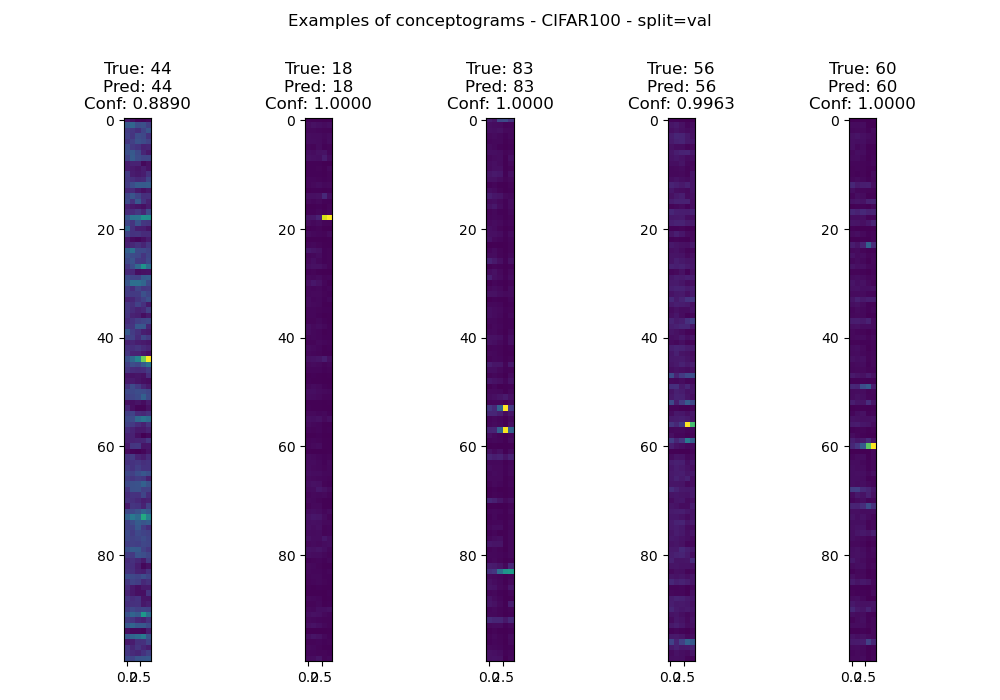

In [34]:
split = 'val'

n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(10, 7))
fig.suptitle(f'Examples of conceptograms - {dataset} - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs[split][i])
    axs[i].set_title(f'True: {int(true[split][i])}\nPred: {int(pred[split][i])}\nConf: {o_dnn_dfs[split]['max'][i]:.4f}')

plt.tight_layout()

In [35]:
classes = ds.get_classes()

In [36]:
df = o_dnn_dfs[split]

In [37]:
df_sorted = df.sort_values(by='max', ascending=False)
df_sorted

,max,entropy,label,true,result
9999,1.000000,1.000000,78,78,True
1998,1.000000,1.000000,7,7,True
8857,1.000000,1.000000,7,7,True
8856,1.000000,1.000000,46,46,True
4822,1.000000,1.000000,6,6,True
...,...,...,...,...,...
3322,0.191657,0.384988,84,98,False
8401,0.187179,0.394365,45,63,False
1881,0.182511,0.393813,7,91,False
5943,0.172331,0.378642,42,99,False


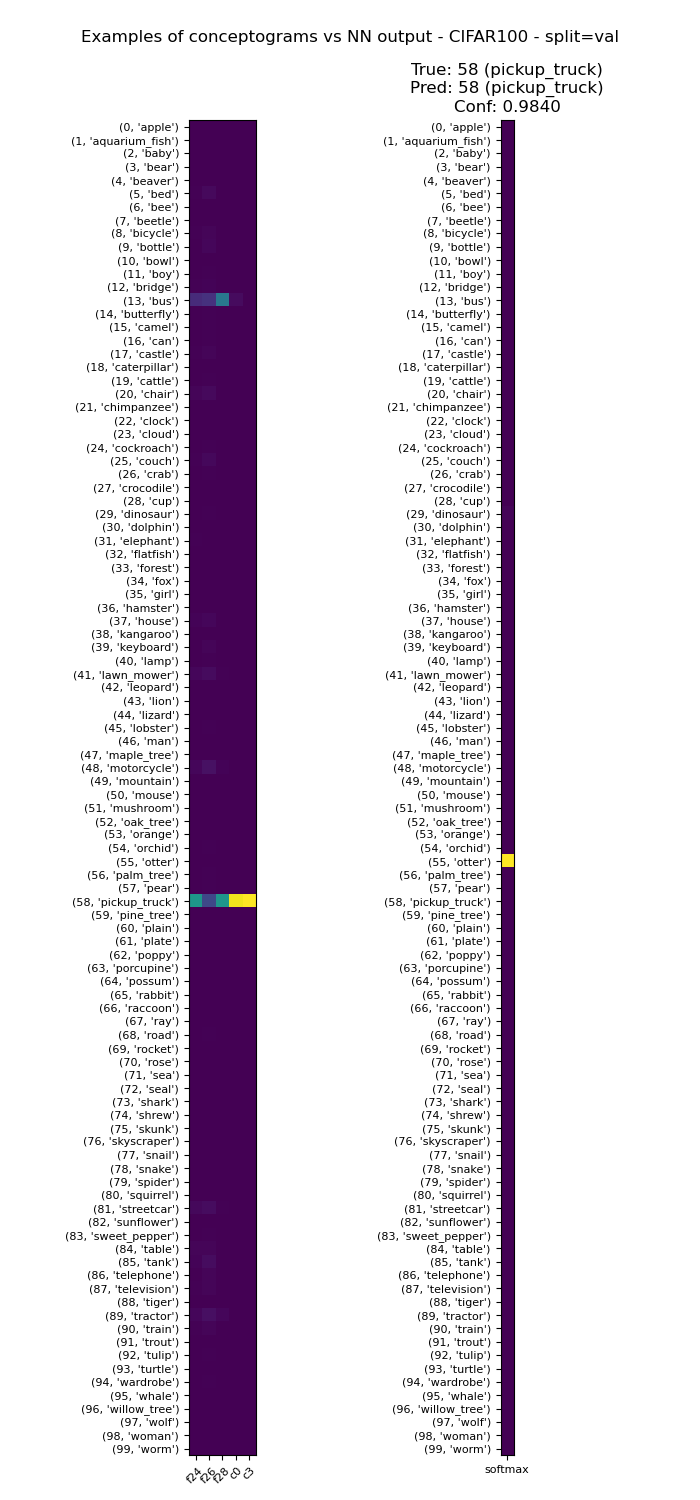

In [38]:
split = 'val'

idx = 398    # 

x_labels = ['f24', 'f26', 'f28', 'c0', 'c3']
y_labels = list(ds.get_classes().keys())

fig, axs = plt.subplots(1, 2, figsize=(7, 15))
fig.suptitle(f'Examples of conceptograms vs NN output - {dataset} - split={split}\n')

axs[0].imshow(cgs[split][idx])

true_l = int(true[split][idx])
pred_l = int(pred[split][idx])
conf = o_dnn_dfs[split]['max'][idx] # qua scegli la confidenza
axs[1].set_title(f'True: {true_l} ({classes[true_l]})\nPred: {pred_l} ({classes[pred_l]})\nConf: {conf:.4f}')
axs[1].imshow(o_dnn[split][idx].reshape(-1, 1))

axs[0].set_xticks(range(len(x_labels)))
axs[0].set_xticklabels(x_labels, fontsize=8, rotation=45)
axs[0].set_yticks(y_labels)
axs[0].set_yticklabels(list(classes.items()), fontsize=8)

axs[1].set_xticks([0])
axs[1].set_xticklabels(['softmax'], fontsize=8)
axs[1].set_yticks(y_labels)
axs[1].set_yticklabels(list(classes.items()), fontsize=8)

plt.tight_layout()